In [ ]:
!unzip "sample_data/part_1_cnn_dataset.zip" -d "sample_data/"

RESNET 18

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [23]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=36):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=36):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


Without optimisation techniques 

In [24]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = ImageFolder(root='sample_data/cnn_dataset', transform=transform)

# Split dataset into training, validation, and testing sets
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define model, loss function, and optimizer
model = resnet18(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=5):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [],[]

    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(valid_loader.dataset)
        val_acc = correct / total

        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'dsivapra_rkota2_bonus_part1.pth')

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    print(f'Best val Acc: {best_acc:4f}')

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, criterion, optimizer, num_epochs=5)


Epoch 0/4, Train Loss: 0.4756, Train Acc: 0.8359, Val Loss: 0.3397, Val Acc: 0.8717
Epoch 1/4, Train Loss: 0.3039, Train Acc: 0.8877, Val Loss: 0.3385, Val Acc: 0.8748
Epoch 2/4, Train Loss: 0.2627, Train Acc: 0.9008, Val Loss: 0.2751, Val Acc: 0.8969
Epoch 3/4, Train Loss: 0.2437, Train Acc: 0.9070, Val Loss: 0.3012, Val Acc: 0.8901
Epoch 4/4, Train Loss: 0.2263, Train Acc: 0.9130, Val Loss: 0.2575, Val Acc: 0.9042
Best val Acc: 0.904167


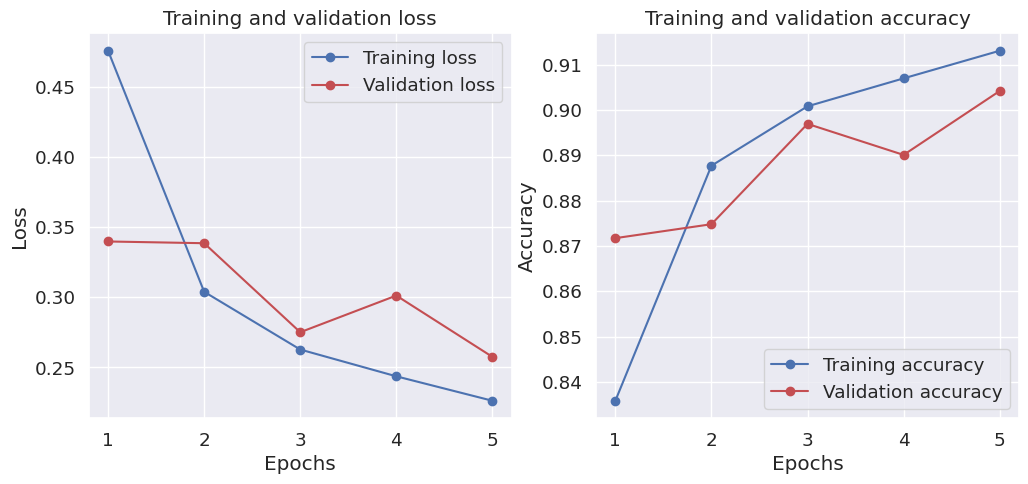

In [25]:
import matplotlib.pyplot as plt

# Plot the results
epochs = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

With optimisation techniques (data augmentation,dropout)

In [26]:
import torch.optim as optim

# Update the transform to include data augmentation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Redefine the dataset with the new transform
dataset = ImageFolder(root='sample_data/cnn_dataset', transform=transform)

# Split dataset again with new transformations
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the BasicBlock and ResNet classes (as previously defined)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=36):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Added dropout layer

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before the final fully connected layer
        x = self.fc(x)

        return x

def resnet18(num_classes=36):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model with the updated dataset and transformations

# Training function
def train_model1(model, criterion, optimizer, num_epochs=5):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [],[]

    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(valid_loader.dataset)
        val_acc = correct / total

        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'dsivapra_rkota2_bonus_part1_optimisation.pth')

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    print(f'Best val Acc: {best_acc:4f}')

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model1(model, criterion, optimizer, num_epochs=5)


Epoch 0/4, Train Loss: 0.8312, Train Acc: 0.7261, Val Loss: 0.4932, Val Acc: 0.8311
Epoch 1/4, Train Loss: 0.4999, Train Acc: 0.8268, Val Loss: 0.4340, Val Acc: 0.8441
Epoch 2/4, Train Loss: 0.4308, Train Acc: 0.8494, Val Loss: 0.3931, Val Acc: 0.8675
Epoch 3/4, Train Loss: 0.3969, Train Acc: 0.8593, Val Loss: 0.3851, Val Acc: 0.8602
Epoch 4/4, Train Loss: 0.3729, Train Acc: 0.8677, Val Loss: 0.3914, Val Acc: 0.8725
Best val Acc: 0.872520


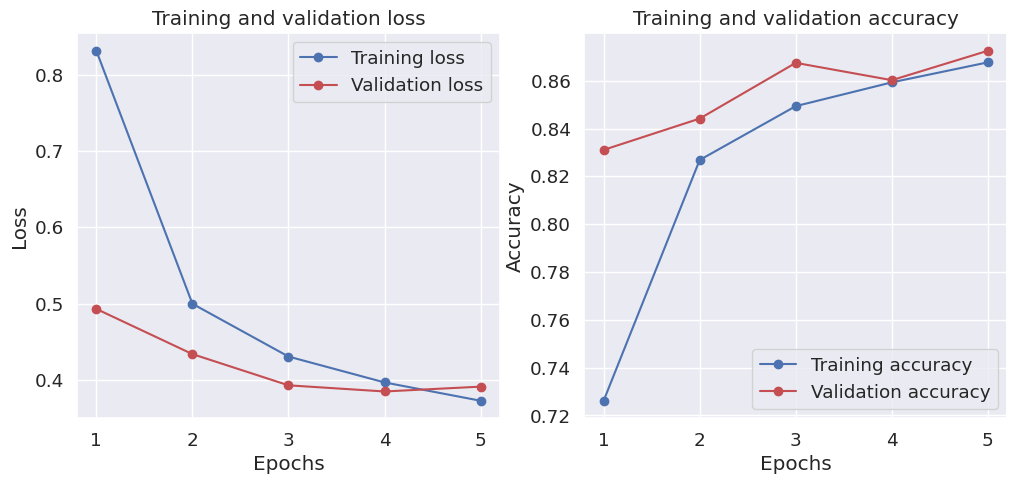

In [27]:
import matplotlib.pyplot as plt

# Plot the results
epochs = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get true labels and predicted labels
y_true, y_pred = evaluate_model(model, test_loader)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate other evaluation metrics using classification_report
class_names = [str(i) for i in range(36)]  # Assuming 36 classes
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
[[146   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 238 ...   0   0  15]
 ...
 [  0   0   0 ... 261   0   1]
 [  0   0   0 ...   6 225   0]
 [  0   0  16 ...   3   0 245]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       254
           1       0.54      0.59      0.56       280
           2       0.90      0.86      0.88       276
           3       0.86      0.97      0.91       263
           4       0.82      0.91      0.86       261
           5       0.75      0.87      0.80       263
           6       0.95      0.98      0.96       287
           7       0.94      0.93      0.93       288
           8       0.97      0.94      0.95       299
           9       0.90      0.89      0.90       273
          10       0.98      0.93      0.95       295
          11       0.93      0.92      0.92       271
          12       0.92      0.97      0.94       291
         

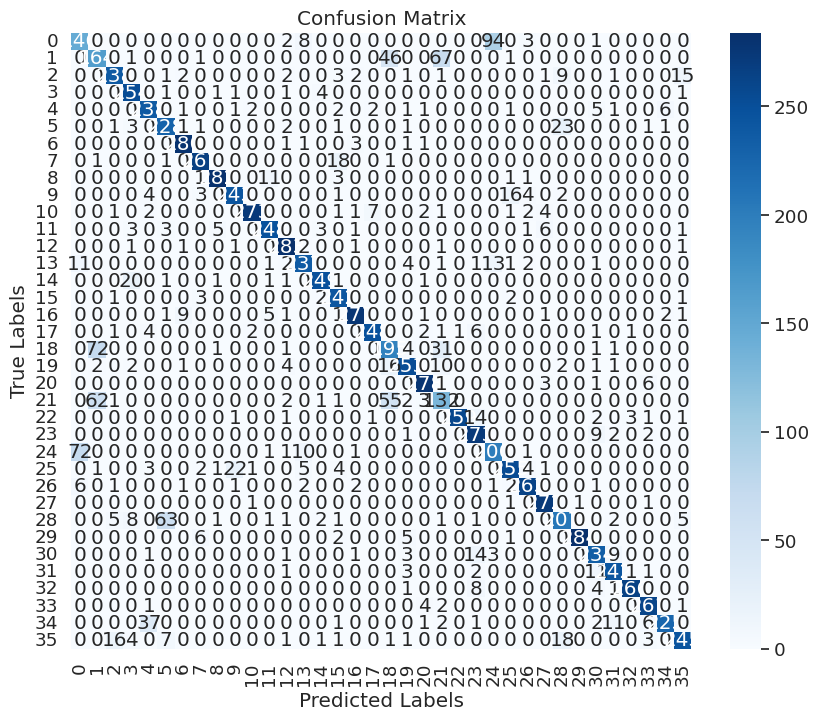

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have the class names defined as a list called class_names
class_names = [str(i) for i in range(36)]  # Assuming 36 classes
plot_confusion_matrix(conf_matrix, class_names)
